In [22]:
import numpy as np
import pandas as pd
import math as mth
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [23]:
# sandp500 = pd.read_csv ('sandp500/all_stocks_5yr.csv')
# sandp500['date'] = pd.to_datetime(sandp500['date'])

company = pd.read_csv('sandp500/individual_stocks_5yr/individual_stocks_5yr/AAPL_data.csv')
company['date'] = pd.to_datetime(company['date'])

In [24]:
#Function that returns specific time-range stockvalues for a particular company
def period(df, initial, final):
    df = df.set_index(['date'])
    return df.loc[initial:final].reset_index()

# (1) AD Analysis

In [25]:
# Standard code for working on specific time-range stockvalues for a particular company
def AD (company, p):
    #p = 14: Time period (in days)
    initial = company['date'][0]
    final = initial + pd.Timedelta(p, unit='d')
    itr = 1 # To start the process for the 1st iteration
    output = []
    last_elem = company['date'].iloc[-1]

    while final <= last_elem:
        temp = period(company, initial, final) #A pandas frame with only the stocks in the particular time range

        '''
        Do all the analysis here with temp
        '''
        if itr == 1:
            v = temp['volume'].sum()
            c = temp['close'][len(temp)-1]
            h = temp['high'].max()
            l = temp['low'].min()
            AD = v * (((c - l) - (h - c))/(h - l))
        else:
            v = temp['volume'].sum()
            AD += v * (((c - l) - (h - c))/(h - l))
            c = temp['close'][len(temp)-1]
            h = temp['high'].max()
            l = temp['low'].min()
            output.append(AD)

        initial += pd.Timedelta(1, unit='d')
        final += pd.Timedelta(1, unit='d')
        itr = 0

    return output

# (2) GOPALAKRISHNAN RANGE INDEX (GAPO Index)

In [26]:
# Standard code for working on specific time-range stockvalues for a particular company
def GAPO (company, p):
    initial = company['date'][0]
    final = initial + pd.Timedelta(p, unit='d')
    output = []
    last_elem = company['date'].iloc[-1]

    while final <= last_elem:
        temp = period(company, initial, final) #A pandas frame with only the stocks in the particular time range
        hh = temp['high'].max()
        ll = temp['low'].min()
        GAPO = np.log(hh-ll)/np.log(p)
        output.append(GAPO)

        initial += pd.Timedelta(1, unit='d')
        final += pd.Timedelta(1, unit='d')

    return output

# (3) LINEAR REGRESSION FORECAST (LRF)

In [27]:
# Standard code for working on specific time-range stockvalues for a particular company
def LRF (company, p):
    initial = company['date'][0]
    final = initial + pd.Timedelta(p, unit='d')
    output = [[],[],[]]
    last_elem = company['date'].iloc[-1]

    while final <= last_elem:
        temp = period(company, initial, final) #A pandas frame with only the stocks in the particular time range
        
        temp['average'] = temp.apply(lambda row: (row.high + row.low)/2. , axis = 1)         
        x = np.array(temp.apply(lambda row: row.date.value/10**9/86400, axis = 1))
        output[0].extend(x)
        output[1].extend(temp['average'])
        
        answer = LinearRegression().fit(x.reshape(-1, 1), np.array(temp['average']).reshape(-1, 1),)
        output[2].extend(answer.coef_[0][0]*x + answer.intercept_[0])       

        initial = final + pd.Timedelta(1, unit='d')
        final = initial + pd.Timedelta(p, unit='d')

    return output

# (4) On Balance Volume (OBV)

In [28]:
# Standard code for working on specific time-range stockvalues for a particular company
def OBV (company, p):
    initial = company['date'][0]
    final = initial + pd.Timedelta(p, unit='d')
    output = []
    itr=1
    obv = 0
    last_elem = company['date'].iloc[-1]

    while final <= last_elem:
        temp = period(company, initial, final) #A pandas frame with only the stocks in the particular time range
        v = temp['volume'].sum()
        
        if itr==1:
            c = temp['close'][len(temp)-1]
            obv = v
        
        else:
            if temp['close'][len(temp)-1] > c:
                obv += v
            elif temp['close'][len(temp)-1] < c:
                obv -= v
            else:
                obv = obv
                
        output.append(obv)

        initial += pd.Timedelta(1, unit='d')
        final += pd.Timedelta(1, unit='d')
        
        c = temp['close'][len(temp)-1]
        itr = 0

    return output

# (5) Relative Strength Index (RSI)

In [29]:
# Standard code for working on specific time-range stockvalues for a particular company
def RSI (company, p):
    initial = company['date'][0]
    final = initial + pd.Timedelta(p, unit='d')
    output = []
    itr = 1
    rsi = 0
    loss = []
    profit = []
    last_elem = company['date'].iloc[-1]

    while final <= last_elem:
        temp = period(company, initial, final) #A pandas frame with only the stocks in the particular time range
        
        for row in range(1, len(temp)):
            if temp['close'][row] < temp['close'][row-1]:
                loss.append(100*(temp['close'][row-1] - temp['close'][row])/temp['close'][row-1])
            else:
                profit.append(100*(temp['close'][row] - temp['close'][row-1])/temp['close'][row-1])
        
        if loss == []:
            loss = [0]
        if profit == []:
            profit = [0]
            
        loss = np.mean(loss)/p
        profit = np.mean(profit)/p
        
        if itr == 1:
            rsi = 100 - (100 / (1+profit/loss) )
        else:
            rsi = 100 - (100 / (1 + ((prev_profit)*(p-1) + profit)/((prev_loss)*(p-1) + loss)))
            
        output.append(rsi)

        initial += pd.Timedelta(1, unit='d')
        final += pd.Timedelta(1, unit='d')
        itr = 0
        prev_loss = loss
        loss = []
        prev_profit = profit
        profit = []

    return output

# (6) Weighted Close (WC)

In [30]:
# Standard code for working on specific time-range stockvalues for a particular company
# Note there is no time granularity for WC analysis
def WC(company):         
    output = company.apply(lambda row: (row.high + row.low + 2*row.close)/4, axis = 1)

    return output

# (7) Williams %R Formula (WRF)

In [35]:
# Standard code for working on specific time-range stockvalues for a particular company
def WRF (company, p):
    initial = company['date'][0]
    final = initial + pd.Timedelta(p, unit='d')
    output = []
    last_elem = company['date'].iloc[-1]

    while final <= last_elem:
        temp = period(company, initial, final) #A pandas frame with only the stocks in the particular time range
        hh = temp['high'].max()
        ll = temp['low'].min()
        close = temp['close'].iloc[-1]
        WR = (hh-close)/(hh-ll)*(-100)
        output.append(WR)

        initial += pd.Timedelta(1, unit='d')
        final += pd.Timedelta(1, unit='d')

    return output

# (8) Aaron Oscillator (AO)

In [56]:
# Standard code for working on specific time-range stockvalues for a particular company
def AO (company):
    p = 25
    initial = company['date'][0]
    final = initial + pd.Timedelta(p, unit='d')
    output = [[],[],[]]
    last_elem = company['date'].iloc[-1]
    first_run = True
    ctr1 = 0
    ctr2 = 0
    hh = 0
    ll = 0

    while final <= last_elem:
        temp = period(company, initial, final) #A pandas frame with only the stocks in the particular time range            
        
        if first_run or ctr1 == 25:
            hh = temp['high'].max()
            ctr1 = len(temp) - temp['high'].values.argmax() - 2
            
        if first_run or ctr2 == 25:
            ll = temp['low'].min()
            ctr2 = len(temp) - temp['low'].values.argmin() - 2

        if temp['high'].iloc[-1] >= hh:
            ctr1 = 0
            hh = temp['high'].iloc[-1]
        else: 
            ctr1 += 1
            
        if temp['low'].iloc[-1] <= ll:
            ctr2 = 0
            ll = temp['low'].iloc[-1]
        else: 
            ctr2 += 1
        
        a_up = 100*(p-ctr1)/p
        a_down = 100*(p-ctr2)/p
        a_osc = a_up - a_down            
        output[0].append(a_osc)
#         output[1].append(a_up)
#         output[2].append(a_down)

        initial += pd.Timedelta(1, unit='d')
        final += pd.Timedelta(1, unit='d') 
        first_run = False

    return output

# "MAIN FUNCTION"

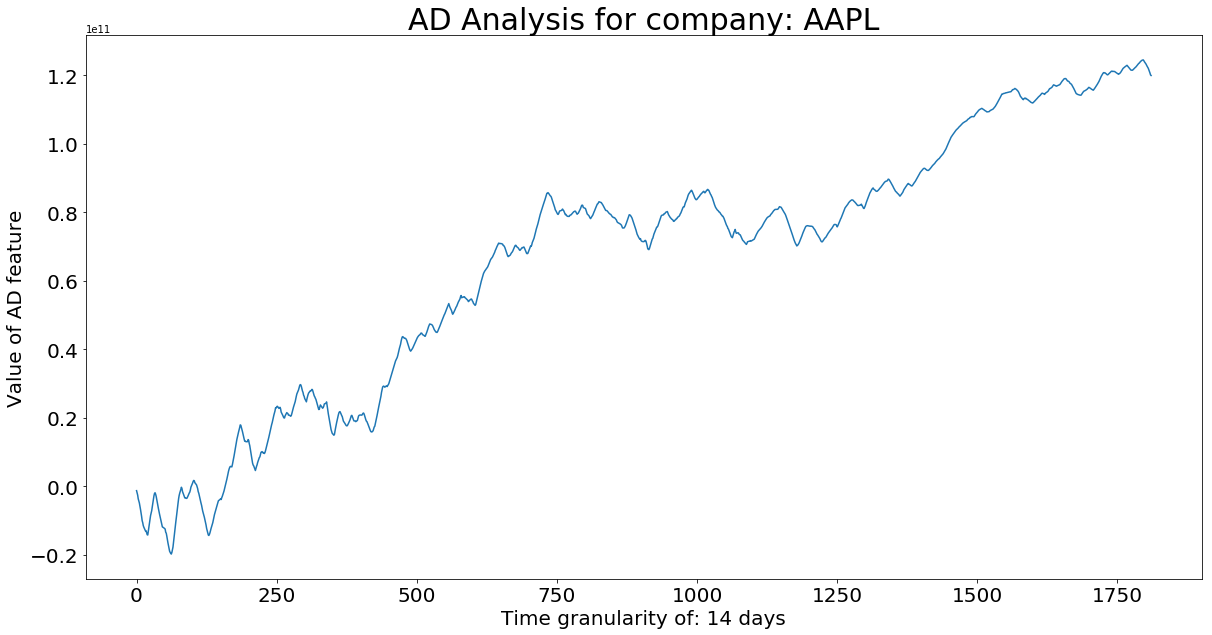

In [67]:
output=[]
p = 14 # Time period in days
analysis = 'AD' # What type of feature to use for our analysis

fig, ax = plt.subplots(figsize=(20,10))
ax.tick_params(axis='both', labelsize=20)

if analysis == 'AD':
    output = AD(company, p)
if analysis == 'GAPO':
    output = GAPO(company, p)
if analysis == 'OBV':
    output = OBV(company, p)
if analysis == 'RSI':
    output = RSI(company, p)
if analysis == 'WC':
    output = WC(company)
if analysis == 'WRF':
    output = WRF(company, p)
if analysis == 'AO':
    output = AO(company)

if analysis == 'LRF':
    output = LRF(company, p)
    plt.plot(output[0], output[1], label='High-Low Average')
    plt.plot(output[0], output[2], label='Linear Reg Fit')
    plt.xlabel('Time in Days', size = 20)
    plt.ylabel('Price (in USD)', size = 20)
    plt.title('Stocks for {0}'.format(company['Name'].iloc[0]), size =30)
    plt.legend()
    
if analysis == 'AO':
    output = AO(company)
    plt.plot(output[0])
    plt.xlabel('Time in Days', size = 20)
    plt.ylabel('Aaron Oscillator Values', size = 20)
    plt.title('Aaron Oscillator values for {0}'.format(company['Name'].iloc[0]), size =30)
    plt.show()
    
#     fig, ax = plt.subplots(figsize=(20,10))
#     ax.tick_params(axis='both', labelsize=20)
#     plt.plot(output[1], label='Aaron UP')
#     plt.plot(output[2], label='Aaron DOWN')
#     plt.xlabel('Time in Days', size = 20)
#     plt.ylabel('Aaron Oscillator Values', size = 20)
#     plt.title('Aaron UP and DOWN for Apple', size =30)
#     plt.legend()
#     plt.show()    

if not analysis == 'LRF' and not analysis == 'AO':
    plt.plot(output)
    plt.title('{0} Analysis for company: {1}'.format(analysis, company['Name'].iloc[0]), size = 30)
    plt.xlabel('Time granularity of: {0} days'.format(p), size = 20)
    plt.ylabel('Value of {0} feature'.format(analysis), size = 20)

In [66]:
company.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,67.7142,68.4014,66.8928,67.8542,158168416,AAPL
1,2013-02-11,68.0714,69.2771,67.6071,68.5614,129029425,AAPL
2,2013-02-12,68.5014,68.9114,66.8205,66.8428,151829363,AAPL
3,2013-02-13,66.7442,67.6628,66.1742,66.7156,118721995,AAPL
4,2013-02-14,66.3599,67.3771,66.2885,66.6556,88809154,AAPL
